### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 1: Credit Analytics

### Team members: Valente Francesco, Skorkowski Tomasz, Schaufelbühl Andreas

In [1]:
%%capture
#!pip install keras==3.1.1 -qq
#!pip install tensorflow.keras.callbacks -qq

In [2]:
### Import all the Python libraries you are going to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union
import math

In [3]:
### Fix random seed for reproducibility
np.random.seed(10)

# Exercise 1. Dataset features generation.

In [4]:
# Data set params
age_lower_bound = 18
age_upper_bound = 80.000001

income_lower_bound = 1
income_upper_bound = 15.000001

p_self_employed = .1

# train set power
m = int(2e4)
# test set power
n = int(1e4)

feature_headers = ['age', 'income', 'self_employed']

# Age ,income and employment data
data = pd.DataFrame((np.random.uniform(age_lower_bound,age_upper_bound, m+n),
                     np.random.uniform(income_lower_bound,income_upper_bound, m+n),
                     np.random.binomial(1, p_self_employed, size = m+n))).transpose()
data.columns=feature_headers

# Set up df to collect results and corresponding losses
df_results = pd.DataFrame(columns=['model', 'test_loss', 'train_loss'])

### Investigate generated features

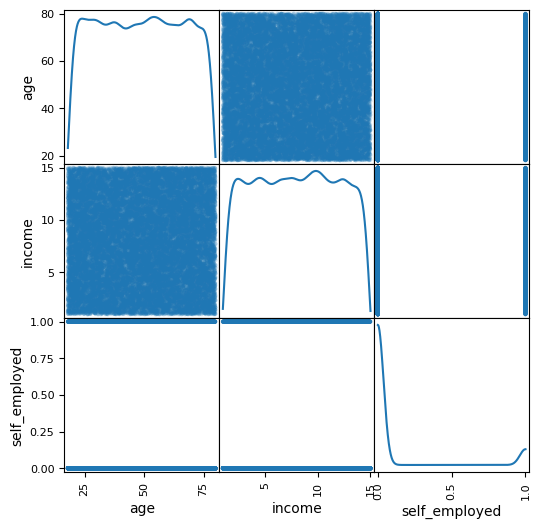

In [5]:
# Plot scatter matrix
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(6, 6),diagonal='kde')
plt.show()

1. We can observe that features have aproximately distributions as specified in the requirements
2. Graphs do not show any obvious correlation between covariates

In [6]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

normalized_data.cov()

,age,income,self_employed
age,1.000033,0.004466,-0.000978
income,0.004466,1.000033,0.001806
self_employed,-0.000978,0.001806,1.000033


Also covariance matrix of standarised features show no correlation between the fetures. This is to be expected given that the variables were simulated independently, ie. as instructed.

Lets look at the distributinos of individual features

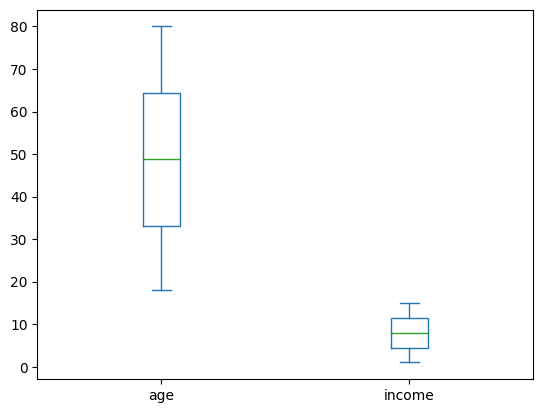

In [7]:
data[['age', 'income']].plot(kind='box')
plt.show()

In [8]:
data[['self_employed']].value_counts(normalize=True)

self_employed
0.0              0.898967
1.0              0.101033
Name: proportion, dtype: float64

In [9]:
data.describe()

,age,income,self_employed
count,30000.000000,30000.000000,30000.000000
mean,48.844797,7.987606,0.101033
std,17.965029,4.026278,0.301378
min,18.004268,1.000025,0.000000
25%,33.195964,4.498722,0.000000
50%,48.927875,7.995084,0.000000
75%,64.411589,11.453036,0.000000
max,79.999369,14.999594,1.000000


Conclusion: data has been generated according to the specification

# Exercise 2. Dataset labels generation.

In [10]:
# Define logistic function
def logistic(z:float) -> float:
    return 1 / (1 + np.exp(-z))

# Define p1 parameters and function
p1_intecept = -13.3
p1_coeff = np.array([0.33,-3.5,3])

def p1(intecept: float, coeff: float, row:float) -> float:
    z = intecept + np.dot(coeff, row)
    return logistic(z)

# Define p2 parameters and function
p2_intecept = -5
p2_coeff = np.array([10,-1.1,1])
age_lower_bound_p2 = 25
age_upper_bound_p2 = 75


#function returning (indicator) function with specific lower and upper boundary
def indic(low_bound: float, up_bound: float):
    assert low_bound <= up_bound, 'lower boundry has to be less or equal to upper boundry'
    def arg(x):
        return 1 if x < low_bound or x > up_bound else 0
    return arg

# Define indicator function returning 1 below lower_bound (25),
# or above upper_bound (75) and 0 in between
p2_indicator = indic(age_lower_bound_p2, age_upper_bound_p2)

def p2(intecept: float, coeff: float, row:float, indicator:indic)-> float:

    row_trasformed = row.copy()
    # Transform age (x_1) into x'_1 applying indicator function
    # ie x'_1(x1) = 1_(−∞,25)(x1) − 1_(75,∞)(x1)
    row_trasformed.loc['age'] = p2_indicator(row_trasformed.loc['age'])

    # take a linear combination of x'_1, x_2, x_3 and coefficients of p2
    z = intecept + np.dot(coeff, row_trasformed)
    return logistic(z)

$\psi(-5 + 10[1_{(-\infty,25)}(x_1)+ 1_{(75,\infty)}(x_1)] - 1.1x_2 + x_3) = \psi(-5 + 10x'_1 - 1.1x_2 + x_3)$

where

$x'_1 = 1_{(-\infty,25)}(x_1)+ 1_{(75,\infty)}(x_1)$

In [11]:
df_prob = pd.DataFrame()
df_prob['p_1'] = data.apply(lambda row: p1(p1_intecept, p1_coeff, row), axis = 1)
df_prob['p_2'] = data.apply(lambda row: p2(p2_intecept, p2_coeff, row, p2_indicator), axis = 1)

df_prob.describe()

,p_1,p_2
count,3.000000e+04,3.000000e+04
mean,5.039505e-02,5.208224e-02
std,1.953120e-01,1.914536e-01
min,1.115391e-26,4.601111e-10
25%,8.564344e-17,6.625024e-08
50%,1.575547e-11,7.143739e-06
75%,2.932197e-06,3.776501e-04
max,9.999963e-01,9.924480e-01


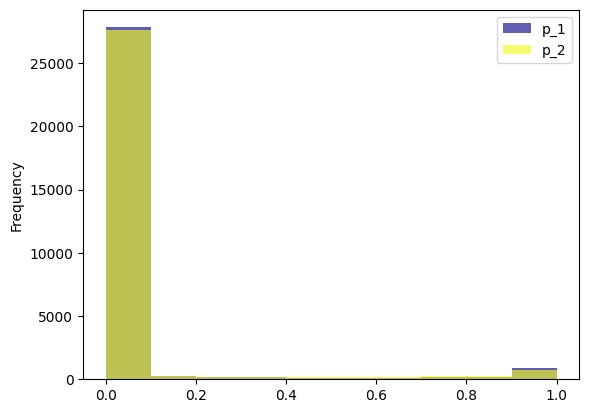

In [12]:
df_prob.plot(kind='hist', colormap='plasma', alpha = .65)
plt.show()

In [13]:
df_default = pd.DataFrame()
for i, col in enumerate(df_prob.columns):
    df_default['y_'+str(i+1)] = np.random.binomial(1, df_prob[col])

In [14]:
# Split into test train datasets
X_train = data.loc[:m-1]
X_test = data.loc[m:]

Y_train = df_default.loc[:m-1]
Y_test = df_default.loc[m:]

In [15]:
print('Summary:',
       df_default.value_counts(['y_1'], normalize=True),
       df_default.value_counts(['y_2'], normalize=True),
       sep='\n')

Summary:
y_1
0      0.948633
1      0.051367
Name: proportion, dtype: float64
y_2
0      0.948567
1      0.051433
Name: proportion, dtype: float64


# Exercise 3. Model implementations.

In [16]:
from sklearn.linear_model import LogisticRegression # logistic regression model
from sklearn.metrics import log_loss # Cross-entropy
from typing import Union
from keras.regularizers import l2
import keras

In [17]:
# For comaprison log loss based on the naive prediction (ie. frequency in Y_train data)
naive_pred_1 = Y_train['y_1'].value_counts(normalize=True)[1]
naive_pred_2 = Y_train['y_2'].value_counts(normalize=True)[1]

log_loss_naive_1_train = log_loss(Y_train['y_1'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_1_test = log_loss(Y_test['y_1'], [naive_pred_1] * Y_test.shape[0])

print((f'''
Naive probability prediction based on the frequency in p_1: {naive_pred_1}
Log loss based on naive prediction, train data: {log_loss_naive_1_train}
Log loss based on naive prediction, test data: {log_loss_naive_1_test}
'''))

log_loss_naive_2_train = log_loss(Y_train['y_2'], [naive_pred_1] * Y_train.shape[0])
log_loss_naive_2_test = log_loss(Y_test['y_2'], [naive_pred_1] * Y_test.shape[0])

print((f'''
Naive probability prediction based on the frequency in p_2: {naive_pred_2}
Log loss based on naive prediction, train data: {log_loss_naive_2_train}
Log loss based on naive prediction, test data: {log_loss_naive_2_test}
'''))

df_results.loc[len(df_results.index)] = ['Naive', log_loss_naive_2_test, log_loss_naive_2_train]


Naive probability prediction based on the frequency in p_1: 0.0514
Log loss based on naive prediction, train data: 0.20261700624514914
Log loss based on naive prediction, test data: 0.20232547134105094


Naive probability prediction based on the frequency in p_2: 0.0509
Log loss based on naive prediction, train data: 0.20115933172465794
Log loss based on naive prediction, test data: 0.20582389019022976



In [18]:
# Given that we know the true distribution compute ireducible error/loss on train/test sets

log_loss_irreducible_1_train = log_loss(Y_train['y_1'], df_prob['p_1'][:m])
log_loss_irreducible_1_test = log_loss(Y_test['y_1'], df_prob['p_1'][m:])

print(f'''
Irreducible error in y_1
True error on the training data: {log_loss_irreducible_1_train}
True error on the test data: {log_loss_irreducible_1_test}
''')

log_loss_irreducible_2_train = log_loss(Y_train['y_2'], df_prob['p_2'][:m])
log_loss_irreducible_2_test = log_loss(Y_test['y_2'], df_prob['p_2'][m:])

print(f'''
Irreducible error in y_2
True error on the training data: {log_loss_irreducible_2_train}
True error on the test data: {log_loss_irreducible_2_test}
''')

df_results.loc[len(df_results.index)] = ['True', log_loss_irreducible_2_test, log_loss_irreducible_2_train]


Irreducible error in y_1
True error on the training data: 0.03226197926237395
True error on the test data: 0.03477630156060681


Irreducible error in y_2
True error on the training data: 0.041199726500333565
True error on the test data: 0.042955581488156654



### 3a) Logistic regression (LR)

In [22]:
# Create container for the model and it's main characteristics
from sklearn.linear_model import LogisticRegression
import textwrap

class MlModelClassification():
    def __init__(self,
                 name: str,
                 model: Union[LogisticRegression, keras.Sequential]):
        self._name = name
        self._model = model
        self._type = type(model)

    @property
    def model(self) -> float:
        return self._model

    @property
    def model_type(self) -> str:
        return self._type

    @property
    def log_loss_train(self) -> float:
        return self._log_loss_train

    @log_loss_train.setter
    def log_loss_train(self, loss: float):
        self._log_loss_train = loss

    @property
    def log_loss_test(self) -> float:
        return self._log_loss_test

    @log_loss_test.setter
    def log_loss_test(self, loss: float):
        self._log_loss_test = loss

    def __str__(self):
        return textwrap.dedent(f'''
                ML model: {self._name}
                Type: {self._type}
                Log loss on the training data: {self._log_loss_train:.4f}
                Log loss on the test data: {self._log_loss_test:.4f}''')


class LrModel(MlModelClassification):
    def __init__(self, name: str, model: LogisticRegression):
        super().__init__(name, model)

    def __str__(self):
        return textwrap.dedent(f'''{super().__str__()}
                               Coefficients: {self._model.coef_}
                               Intercept: {self._model.intercept_}''')

class NnModel(MlModelClassification):
    def __init__(self, name: str, model: keras.Sequential):
        super().__init__(name, model)

    @property
    def history(self) :
        return self._history

    @history.setter
    def history(self, history):
        self._history = history

In [23]:
# Implement and train a logistic regression model
# You can use LogisticRegression() from sklearn.linear_model (see the notebook "Project 1 - Sandbox.ipynb")
# For more information, see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

# Attention! Set the argument penalty=None to implement a logistic regression without regularization
lr_models = []
for i, col in enumerate(Y_train.columns):
    lr = LrModel(name = 'LR_Default_'+ str(i+1),
                  model = LogisticRegression(penalty=None).fit(X_train, Y_train[col]))
    lr.log_loss_train = log_loss(Y_train[col], lr.model.predict_proba(X_train)[:,1])
    lr.log_loss_test = log_loss(Y_test[col], lr.model.predict_proba(X_test)[:,1])
    lr_models.append(lr)

df_results.loc[len(df_results.index)] = ['LR', lr.log_loss_test, lr.log_loss_train]

In [ ]:
# ICE plots
sample = np.random.randint(low = 0, high = X_test.shape[0],size=20)


In [ ]:
for feature in feature_headers:
  fig, ax = plt.subplots(1,2,figsize= [16, 8])
  for i, col in enumerate(Y_train.columns):
    model = lr_models[i].model
    sample_range = X_train[feature].sample(n=80, replace=False)
    for k in sample:
      df_ice = pd.DataFrame([X_test.iloc[k]] * len(sample_range))
      df_ice[feature] = np.array(sample_range)
      ax[i].plot(df_ice[feature],model.predict_proba(df_ice)[:,1], c='black', alpha=.2)
    ax[i].set_ylabel('Probability of default')
    ax[i].set_xlabel(f'{feature}')
    ax[i].set_title(f'ICE plot model {lr_models[i]._name}')
plt.show()


In [24]:
# Compute the cross-entropy loss on the training and test data.
for i, lr in enumerate(lr_models):
    print(lr)


ML model: LR_Default_1
Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Log loss on the training data: 0.0319
Log loss on the test data: 0.0356
                               Coefficients: [[ 0.31856348 -3.48915889  3.37599613]]
                               Intercept: [-12.42892673]

ML model: LR_Default_2
Type: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Log loss on the training data: 0.1505
Log loss on the test data: 0.1581
                               Coefficients: [[-0.01647068 -0.51836677  0.19013489]]
                               Intercept: [0.47963443]


Comments:

p1
    
* Logistic regression learned intercept and covariates well in p1 case
* Cross entropy from the logistic regression in close to the true error - we can't du much better

p2

* With non linearity in the model, logistic regression based on linear predictor has problems with finding good parameters
* We can observe that the true error is much lower than either LR train or test error
* Both models perform better than naive model - phew!

### 3b) Neural network (NN)

In [26]:
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 1 - Credit risk - Sandbox")
# For more information, see: https://keras.io/getting_started/

In [27]:
# Define helper functions
def create_and_train_manual_nn(
        name: str,
        numb_neurons: Union[int, list[int]],
        l2_val: Union[float, list[float]],
        activation: Union[str, list[str]],
        lr: float,
        batch_size: int,
        epochs: int,
        training_dataset: int,
        early_stopping: Union[None, EarlyStopping] = None
) -> keras.Sequential:
    """ Helper function to create and train a specific Neural Network architecture of the exercise.
        Neural network parameters are provided as function parameters.

        For the following parameter you can either provide one value, which holds for all layers, or for each layer an individual:
        - numb_neurons
        - l2_val
        - activation
    """
    # Parameter assertion
    assert isinstance(numb_neurons, int) or (len(numb_neurons) == 4 and all(isinstance(n, int) for n in numb_neurons)),"Parameter 'numb_neurons' must be either of type int or list[int] with length 4."
    assert isinstance(l2_val, float) or (len(l2_val) == 3 and all(isinstance(l, float) for l in l2_val)),"Parameter 'l2_val' must be either of type float or list[float] with length 3."
    assert isinstance(activation, str) or (len(activation) == 4 and all(isinstance(a, str) for a in activation)),"Parameter 'activation' must be either of type string or list[str] with length 4."
    assert training_dataset == 0 or training_dataset == 1 ,"Parameter 'training_dataset' must be either 0 or 1"

    # Duplicate params if only single one is provided.
    if isinstance(numb_neurons, int):
        numb_neurons = [numb_neurons] * 4
    if isinstance(l2_val, float):
        l2_val = [l2_val] * 3
    if isinstance(activation, str):
        activation = [activation] * 4
    if early_stopping is None:
        early_stopping = []

    model =  keras.Sequential([
        keras.layers.Dense(numb_neurons[0], kernel_regularizer=l2(l2_val[0]), activation=activation[0]),
        keras.layers.Dense(numb_neurons[1], kernel_regularizer=l2(l2_val[1]), activation=activation[1]),
        keras.layers.Dense(numb_neurons[2], kernel_regularizer=l2(l2_val[2]), activation=activation[2]),
        keras.layers.Dense(numb_neurons[3], activation=activation[3]),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.BinaryCrossentropy()
    )

    print(f"\n\n================= {name}: Start Training =================")
    nn_model =  NnModel(f'{name} - Dataset: {str(training_dataset + 1)}', model)
    nn_model.model.fit(
        x=X_train,
        y=Y_train.iloc[:,training_dataset],
        validation_split=0.2,
        batch_size=batch_size,
        callbacks=[early_stopping],
        epochs=epochs
    )
    return nn_model


def plot_models_history(nn_models: list[NnModel]):
    '''
    For each model provided as parameter,
    plot the history of the cross-entropy loss.
    '''
    numb_m = len(nn_models)
    nrows = math.ceil(numb_m / 2)

    fig = plt.figure()
    fig.set_figheight(8 * nrows)
    fig.set_figwidth(16)

    for i, nn in enumerate(nn_models):
        hist = nn.model.history

        x_pos = math.floor(i/2)
        y_pos = i % 2
        ax = plt.subplot2grid((nrows, 2), (x_pos, y_pos))

        ax.plot(hist.history['loss'], 'b.-')
        ax.set_title(nn._name)
        ax.set_yscale('log')
        ax.set_ylabel('Cross-entropy loss (training data set)')
        ax.set_xlabel('Number of epochs')

    plt.show()


In [28]:
# Implementation of different Neural networks on Dataset 1
nns_dataset_1 = []

nns_dataset_1.append(create_and_train_manual_nn(
    name='NN1',
    numb_neurons=50,
    l2_val=0.01,
    activation='relu',
    lr=0.00035,
    batch_size=1024,
    epochs=500,
    training_dataset= 0,
    early_stopping=EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
))
nns_dataset_1.append(create_and_train_manual_nn(
    name='NN2',
    numb_neurons=60,
    l2_val=0.01,
    activation='relu',
    lr=0.00025,
    batch_size=1024,
    epochs=500,
    training_dataset= 0,
    early_stopping=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
))

nns_dataset_1.append(create_and_train_manual_nn(
    name='NN3',
    numb_neurons=[70, 60, 50, 50],
    l2_val=[0.01, 0.015, 0.02],
    activation='relu',
    lr=0.00025,
    batch_size=1024,
    epochs=500,
    training_dataset= 0,
    early_stopping=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
))



================= NN1: Start Training =================
Epoch 1/500
16/16 [==============================] - 2s 31ms/step - loss: 1.2663 - val_loss: 1.2242
Epoch 2/500
16/16 [==============================] - 0s 8ms/step - loss: 1.1734 - val_loss: 1.1348
Epoch 3/500
16/16 [==============================] - 0s 8ms/step - loss: 1.0887 - val_loss: 1.0518
Epoch 4/500
16/16 [==============================] - 0s 7ms/step - loss: 1.0087 - val_loss: 0.9746
Epoch 5/500
16/16 [==============================] - 0s 7ms/step - loss: 0.9358 - val_loss: 0.9086
Epoch 6/500
16/16 [==============================] - 0s 8ms/step - loss: 0.8728 - val_loss: 0.8466
Epoch 7/500
16/16 [==============================] - 0s 8ms/step - loss: 0.8167 - val_loss: 0.7943
Epoch 8/500
16/16 [==============================] - 0s 8ms/step - loss: 0.7655 - val_loss: 0.7439
Epoch 9/500
16/16 [==============================] - 0s 8ms/step - loss: 0.7174 - val_loss: 0.6992
Epoch 10/500
16/16 [==============================

In [29]:
# Implementation of different Neural networks on Dataset 2
nns_dataset_2 = []

nns_dataset_2.append(create_and_train_manual_nn(
    name='NN1',
    numb_neurons=50,
    l2_val=0.01,
    activation='relu',
    lr=0.00035,
    batch_size=1024,
    epochs=500,
    training_dataset= 1,
    early_stopping=EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
))
nns_dataset_2.append(create_and_train_manual_nn(
    name='NN2',
    numb_neurons=60,
    l2_val=0.01,
    activation='relu',
    lr=0.00025,
    batch_size=1024,
    epochs=500,
    training_dataset= 1,
    early_stopping=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
))

nns_dataset_2.append(create_and_train_manual_nn(
    name='NN3',
    numb_neurons=[70, 60, 50, 50],
    l2_val=[0.01, 0.015, 0.02],
    activation='relu',
    lr=0.00025,
    batch_size=1024,
    epochs=500,
    training_dataset= 1,
    early_stopping=EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
))



================= NN1: Start Training =================
Epoch 1/500
16/16 [==============================] - 1s 20ms/step - loss: 2.6949 - val_loss: 1.2591
Epoch 2/500
16/16 [==============================] - 0s 8ms/step - loss: 1.2029 - val_loss: 1.1882
Epoch 3/500
16/16 [==============================] - 0s 9ms/step - loss: 1.1592 - val_loss: 1.1380
Epoch 4/500
16/16 [==============================] - 0s 9ms/step - loss: 1.1030 - val_loss: 1.0766
Epoch 5/500
16/16 [==============================] - 0s 8ms/step - loss: 1.0462 - val_loss: 1.0219
Epoch 6/500
16/16 [==============================] - 0s 8ms/step - loss: 0.9966 - val_loss: 0.9742
Epoch 7/500
16/16 [==============================] - 0s 7ms/step - loss: 0.9531 - val_loss: 0.9331
Epoch 8/500
16/16 [==============================] - 0s 8ms/step - loss: 0.9147 - val_loss: 0.8959
Epoch 9/500
16/16 [==============================] - 0s 8ms/step - loss: 0.8796 - val_loss: 0.8622
Epoch 10/500
16/16 [==============================

#### Keras-Tuner: Random Search

Base on the [RandomSearch](https://keras.io/api/keras_tuner/tuners/random/)  of keras,
we want to search in an automated way for good  hyperparameters to train with.

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner import Objective

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
# Random search parameter names
name_kern_regular_layer = 'kernel_regularizer_layer'
name_neuron_count_layer = 'neuron_count_layer'
name_learning_rate = 'learning_rate'

In [ ]:
def build_model(hp):
  """
  Build the models with the architecture as before but for RandomSearch.
  Add ranges of values for the different parameters in it.
  """
  model = keras.Sequential()

  # Search optimal values for the first dense layer
  hp_kernel_regularizer_layer1 = hp.Choice(f'{name_kern_regular_layer}_1', values=[0.01, 0.001, 0.001])
  hp_neuron_count_layer1 = hp.Int(f'{name_neuron_count_layer}_1', min_value=20, max_value=100, step=10)
  model.add(layers.Dense(units=hp_neuron_count_layer1, kernel_regularizer=l2(hp_kernel_regularizer_layer1), activation='relu'))

  # Search optimal values for the second dense layer
  hp_kernel_regularizer_layer2 = hp.Choice(f'{name_kern_regular_layer}_2', values=[0.01, 0.001, 0.001])
  hp_neuron_count_layer2 = hp.Int(f'{name_neuron_count_layer}_2', min_value=20, max_value=100, step=10)
  model.add(layers.Dense(units=hp_neuron_count_layer2, kernel_regularizer=l2(hp_kernel_regularizer_layer2), activation='relu'))

  # Search optimal values for the third dense layer
  hp_kernel_regularizer_layer3 = hp.Choice(f'{name_kern_regular_layer}_3', values=[0.01, 0.001, 0.001])
  hp_neuron_count_layer3 = hp.Int(f'{name_neuron_count_layer}_3', min_value=20, max_value=100, step=10)
  model.add(layers.Dense(units=hp_neuron_count_layer3, kernel_regularizer=l2(hp_kernel_regularizer_layer3), activation='relu'))

  # Search optimal values for the fourth dense layer
  hp_neuron_count_layer4 = hp.Int(f'{name_neuron_count_layer}_4', min_value=20, max_value=100, step=10)
  model.add(layers.Dense(units=hp_neuron_count_layer4, activation='relu'))

  model.add(layers.Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice(name_learning_rate, values=[0.0001, 0.0025, 0.00001])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

  return model

In [ ]:

def search_and_train_randomsearch_nn(training_dataset: int):
    """
    Executes a random search for the best hyperparameters using the buld_model function defined above.
    Once finished, it trains a NeuralNetwork with the found hyperparameters and returns it.


    """
    assert training_dataset == 0 or training_dataset == 1 ,"Parameter 'training_dataset' must be either 0 or 1"

    # Initialize RandomSearch on dataset 1
    tuner = RandomSearch(
        build_model,
        objective=Objective('accuracy', 'max'),
        max_trials=1,
        executions_per_trial=1,
        directory='hp_random_search',
        project_name=f'rdataset_{training_dataset}'
    )

    # Search for best hyper parameters
    tuner.search(X_train, Y_train.iloc[:,training_dataset], epochs=40, validation_split=0.2)

    # Initialize a Neural network with this hyperparameters
    best_hp = tuner.get_best_hyperparameters()[0].values
    hp_model = keras.Sequential([keras.layers.Dense(best_hp[f'{name_neuron_count_layer}_1'], kernel_regularizer=l2(best_hp[f'{name_kern_regular_layer}_1']), activation='relu'),
                                keras.layers.Dense(best_hp[f'{name_neuron_count_layer}_2'], kernel_regularizer=l2(best_hp[f'{name_kern_regular_layer}_2']), activation='relu'),
                                keras.layers.Dense(best_hp[f'{name_neuron_count_layer}_3'], kernel_regularizer=l2(best_hp[f'{name_kern_regular_layer}_3']), activation='relu'),
                                keras.layers.Dense(best_hp[f'{name_neuron_count_layer}_4'], activation='relu'),
                                keras.layers.Dense(1, activation='sigmoid')])

    # Compile the network
    hp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_hp[name_learning_rate]),
                        loss=keras.losses.BinaryCrossentropy())
    # Train the model
    hp_model.fit(x=X_train, y=Y_train.iloc[:,training_dataset], validation_split=0.2, batch_size=1024, epochs=500)

    return hp_model

In [ ]:
# Random search for hyperparameter on dataset 1 and 2
hp_nn_1 = search_and_train_randomsearch_nn(0)
nns_dataset_1.append(NnModel('RandomSearch NN_1',
                    model = hp_nn_1))

hp_nn_2 = search_and_train_randomsearch_nn(1)
nns_dataset_2.append(NnModel('RandomSearch NN_2',
                    model = hp_nn_2))

In [ ]:
plot_models_history(nns_dataset_1)

In [ ]:
plot_models_history(nns_dataset_2)

In [ ]:
# Compute the cross-entropy loss on the training and test data.
for i, nn in enumerate(nns_dataset_1):
    nn.log_loss_train = log_loss(Y_train.iloc[:,0], nn.model.predict(X_train))
    nn.log_loss_test = log_loss(Y_test.iloc[:,0], nn.model.predict(X_test))
    print(nn)
df_results.loc[len(df_results.index)] = ['NeuralNet', nn.log_loss_test, nn.log_loss_train]

for i, nn in enumerate(nns_dataset_2):
    nn.log_loss_train = log_loss(Y_train.iloc[:,1], nn.model.predict(X_train))
    nn.log_loss_test = log_loss(Y_test.iloc[:,1], nn.model.predict(X_test))
    print(nn)
df_results.loc[len(df_results.index)] = ['NeuralNet', nn.log_loss_test, nn.log_loss_train]

In [ ]:
#Lets look at combined results on non_linear problem
df_results.sort_values(by='train_loss', ascending = False)

Comments:

* NN_Default_1 is slightly worse when compared to LR_Default_1
* NN_Default_2 seems to perform well, ie much better than logistic regression

### 3c) ROC curves and AUC scores

In [ ]:
# Plot the ROC curves and compute the AUC scores
# You can use roc_auc_score and roc_curve from sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve


# Compare for dataset 1
fig, ax = plt.subplots(1,2,figsize= [16, 8])

# Add logistic regression curves
for i, lr_model in enumerate(lr_models):
    fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test.iloc[:,i], lr_model.model.predict_proba(X_test)[:, 1], pos_label=1)
    auc_LR = roc_auc_score(Y_test.iloc[:,i], lr_model.model.predict_proba(X_test)[:, 1])

    ax[i].plot(fpr_LR, tpr_LR, 'r-', label=f'Logistic regression {i + 1}, AUC={auc_LR:.3f}') #.format(auc_LR)

# Compute FPR and TPR for neural networks on dataset 1
for nn in nns_dataset_1:
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(Y_test.iloc[:,0], nn.model.predict(X_test), pos_label=1)
    auc_NN = roc_auc_score(Y_test.iloc[:,0], nn.model.predict(X_test))

    ax[0].plot(fpr_NN, tpr_NN, label=f'{nn._name}, AUC={auc_NN:.3f}') #.format(auc_NN)

# Compute FPR and TPR for neural networks on dataset 2
for nn in nns_dataset_2:
    fpr_NN, tpr_NN, thresholds_NN = roc_curve(Y_test.iloc[:,0], nn.model.predict(X_test), pos_label=1)
    auc_NN = roc_auc_score(Y_test.iloc[:,0], nn.model.predict(X_test))

    ax[1].plot(fpr_NN, tpr_NN, label=f'{nn._name}, AUC={auc_NN:.3f}') #.format(auc_NN)

#ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].legend()
ax[1].legend()
ax[0].plot([0, 1], [0, 1], 'k--')
ax[1].plot([0, 1], [0, 1], 'k--')
plt.show()

# Exercise 4. Comparison of lending strategies

In [ ]:
# Implement a function to compute the Value at Risk (VaR) at level alpha on the vector x
def var(x, alpha):
    return np.quantile(x,alpha)

In [ ]:
# Simulate scenario matrix
prob_set = 2 # Which set of probabilities, defined at the start, are we interested in {1,2}

df_test_prob = df_prob.iloc[m:,prob_set-1] # p2, test subset of full probability matrix (ie corresponding to Y_test seconde column)

df_scenarios = pd.DataFrame()
num_cols = df_test_prob.shape[0]
num_rows = int(1e3)

# Create scenarios where 1 <=> default
df_scenarios_default = pd.DataFrame(np.random.binomial(1, p=df_test_prob,size=(num_rows, num_cols))).transpose()

# Transform default scenarios by swaping 1's and 0's to get matrix that can be used to calculate profit easily
df_scenarios = np.logical_not(df_scenarios_default).astype(int)

In [ ]:
# Check scenarios, should be small. Cumulative difference of mean estimators and 10000 test set means (ie probability of a success in Bernouli trail)
(df_scenarios.sum(axis=1)/num_rows).sum() - (1-df_test_prob).sum()

In [ ]:
alpha = 0.95
# Implement strategy (i), plot the P&L histogram and compute VaR(95%) of the losses
ir = 5.5/100
loan = 100

investment = 100 * n

# Calculate return per scenario
return_t1 = [loan * (1 + ir)] * n @ df_scenarios

# Calculate profit&loss
P_L_1 = return_t1 - investment

plt.hist(P_L_1)
plt.show()
print(f'95% VaR of strategy (i): {var(-P_L_1, alpha)}')

In [ ]:
# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses
ir = 1/100
loan = 100
application_treshold = 5/100

lr_model = lr_models[1].model
LR2_prob = lr_model.predict_proba(X_test)[:,1]

select_applicants = LR2_prob <= application_treshold

investment = 100 * sum(select_applicants)

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * sum(select_applicants)
                         @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_2 = return_t1 - investment

plt.hist(P_L_2)
plt.show()
print(f'''95% VaR of strategy (iii): {var(-P_L_2, alpha)}
Mean P&L of strategy (iii): {P_L_2.mean()[0]}''')


In [ ]:
# Implement strategy (iii), plot the P&L histogram and compute VaR(95%) of the losses
# Implement strategy (ii), plot the P&L histogram and compute VaR(95%) of the losses
ir = 1/100
loan = 100
application_treshold = 5/100

nn_model = nn_models[1].model
nn2_prob = nn_model.predict(X_test)

select_applicants = nn2_prob <= application_treshold

investment = 100 * select_applicants.sum()

# Calculate return per scenario
return_t1 = pd.DataFrame([100 * (1+ir)] * select_applicants.sum()
                          @ df_scenarios[select_applicants])

# Calculate profit&loss per scenario
P_L_3 = return_t1 - investment

plt.hist(P_L_3)
plt.show()
print(f'''95% VaR of strategy (iii): {var(-P_L_3, alpha)}
Mean P&L of strategy (iii): {P_L_3.mean()[0]}''')


In [ ]:
#Lets look again at combined results on non_linear problem
df_results.sort_values(by='train_loss', ascending = False)

### Comments

* In general business case it's very unlikely that covariates will be independent and that the conditional probability of deafult given features will be a simple linear combination.
* Consequently Neural Netowork is verly likely to outperform Logistic Regression in real world application.
* As we see on the basis of two comparable strategies better model leads to competitive advantage.
* Company with the best model can offer lower interest rate without sacrificing profit. Due to better conditions said company would also attract more customers and make even more profit as a consequence.
* **Note that same selection criteria but based on the model lead to an improvement in expected profit from -1037 to 7608 while eliminatinig downside risk!**
* With a good risk assesment company can make a sound decision about it's risk appetite and also offer loans to the more risky customers. In such case, copmany could also try to optimsie under soldarity/ethical conditions. Ie. not to limit to havily an access to the capital to the most disadventegous social groups.
